In [1]:
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import sys
sys.path.append('../')
from src import *

random.seed(1234)
np.random.seed(1234)

In [2]:
PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
PATH_SAMPLES = "/extra/disij0/data/flow_cytometry/flowMP_output/"
OUTPUT_DIR = "/home/disij/projects/sandbox/fc_mondrian/output/"

Load data...

In [12]:
# load data into a dictionary of pandas data frames
user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)
    
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
    
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

table.at['Mature B cells','CD38'] = -1.0

f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4',\
            'H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

Load accepted samples...

In [10]:
accepts_template_mp_H = load_chains_from_files(PATH_SAMPLES + \
                                               'MP_RE_accepted_template_samples_H')
accepts_template_mp_SJ = load_chains_from_files(PATH_SAMPLES + \
                                               'MP_RE_accepted_template_samples_SJ')

dir_path_H = PATH_SAMPLES + "MP_RE_accepted_indiv_samples_H"
dir_path_SJ = PATH_SAMPLES + "MP_RE_accepted_indiv_samples_SJ"

accepts_indiv_mp_lists_H = [load_chains_from_files(dir_path_H + str(id)) for id in range(1,6)]
accepts_indiv_mp_lists_SJ = [load_chains_from_files(dir_path_SJ + str(id)) for id in range(1,17)]

Compare log likelihood $P(data_i|MP_i)$ without or without random effects...

In [14]:
# fit 1 tree to pooled healthy samples, and 1 tree for pooled unhealthy samples
global_MP_H = []
global_MP_SJ = []
n_iter = 1000
mcmc_gaussin_std = 0.1
data_H = np.concatenate(data[0:5])
n_mcmc_chain = 32
for chain in range(n_mcmc_chain):
    global_MP_H.append(init_mp(theta_space, table, data_H, n_iter,mcmc_gaussin_std))
    
data_SJ = np.concatenate(data[5:])
for chain in range(n_mcmc_chain):
    global_MP_SJ.append(init_mp(theta_space, table, data_SJ, n_iter,mcmc_gaussin_std))

In [19]:
# individual MP with random effects

log_lik_H = [[] for _ in range(5)] # 5 * n_chain
log_lik_SJ = [[] for _ in range(16)] # 5 * n_chain

for id in range(5):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[id][_][-1:]]
    for sample in burnt_samples:
        log_lik_H[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[id][_][-1:]]
    for sample in burnt_samples:
        log_lik_SJ[id].append(comp_log_p_sample(sample, data_subset))

log_lik = log_lik_H + log_lik_SJ 

In [20]:
# individual MP without random effects

log_lik_H_global = [[] for _ in range(5)] # 5 * n_chain * 2
log_lik_SJ_global = [[] for _ in range(16)] # 5 * n_chain * 2

for id in range(5):
    data_subset = data[id]
    for sample in global_MP_H:
        log_lik_H_global[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    for sample in global_MP_SJ:
        log_lik_SJ_global[id].append(comp_log_p_sample(sample, data_subset))

log_lik_global = log_lik_H_global + log_lik_SJ_global

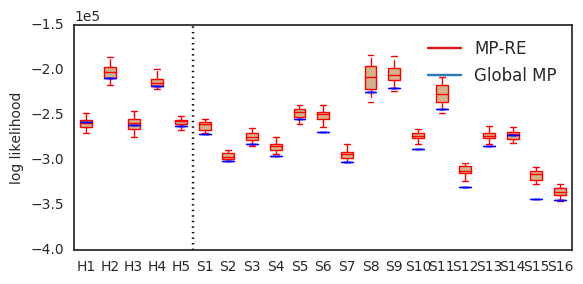

In [33]:
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

fig, ax = plt.subplots(figsize=(6,3))
draw_plot(np.array(log_lik).T, 'red', 'tan')
draw_plot(np.array(log_lik_global).T, 'blue', 'cyan')

ax.set_ylabel('log likelihood',fontsize=10)
#plt.setp(ax.get_yticklabels(),visible=False)

groups = ['H%s' % i for i in range(1,6)] + ['S%s' % i for i in range(1,17)]
plt.plot([], c='#D7191C', label='MP-RE')
plt.plot([], c='#2C7BB6', label='Global MP')
plt.legend(fontsize=12)

plt.plot([5.5, 5.5],[-400000, -150000], c = 'k', linestyle = ':')

plt.xticks(range(1,22),groups)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.xlabel('Subjects')
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.tight_layout()
plt.show()

Random Effect Analysis...

In [24]:
def find_first_cut(theta_space):
            
    # find the dimension and location of first cut when there is a cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break    
    dim, pos = _, left_rec[_,1]
    return dim , pos

def flatten_tree(tree):
    if tree == None:
        return []
    if len(tree) == 1:
        return tree
    else:
        return [tree[0]] + flatten_tree(tree[1]) + flatten_tree(tree[2])
"""
random_effect_H_flattened[patient_id][chain] = a list of unordered offsets
random_effect_SJ_flattened[patient_id][chain] = a list of unordered offsets
"""

    
def compute_diff_mp(template_mp,mp,theta_space):
    """
    Input: 2 mondrian trees
    Output:
        returns mp - tempatlate_mp
        D: tree structured (dimenison of cuts, shared across 2 mp trees), each node is an integer
        C: tree structured (position of cuts), each node is a real value
    """
    if mp[1] == None and mp[2] == None:
        return None, None
    d_0_template, c_0_template = find_first_cut(template_mp)
    d_0_mp, c_0_mp = find_first_cut(mp)
    d_0 = d_0_template
    len_d_0 = theta_space[d_0][1] - theta_space[d_0][0]
    c_0 = (c_0_mp - c_0_template)/len_d_0
    
    D_left, C_left = compute_diff_mp(template_mp[1],mp[1],theta_space)
    D_right, C_right = compute_diff_mp(template_mp[2],mp[2],theta_space)
    D = [d_0, D_left, D_right]
    C = [c_0, C_left, C_right]
    return D, C

In [26]:
random_effect_H = [[None for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ = [[None for chain in range(n_mcmc_chain)] for id in range(21)]

for id in range(5):
    for chain in range(n_mcmc_chain):
        random_effect_H[id][chain] = compute_diff_mp(accepts_template_mp_H[chain][-1],\
                                                     accepts_indiv_mp_lists_H[id][chain][-1],\
                                                    theta_space)
for id in range(16):
    for chain in range(n_mcmc_chain):
        random_effect_SJ[id][chain] = compute_diff_mp(accepts_template_mp_SJ[chain][-1],\
                                                     accepts_indiv_mp_lists_SJ[id][chain][-1],\
                                                     theta_space)

random_effect_H_flattened = [[flatten_tree(random_effect_H[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ_flattened = [[flatten_tree(random_effect_SJ[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(16)]

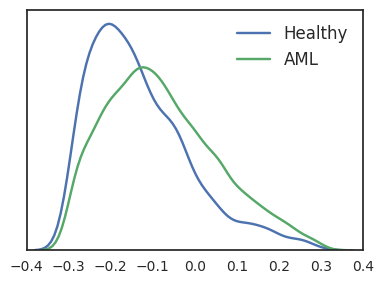

In [31]:
import itertools
import seaborn as sns
sns.set_style("white")
from sklearn.neighbors import KernelDensity

random_effect_H_set = [j for i in random_effect_H_flattened for _ in  i for j in _]
random_effect_SJ_set = [j for i in random_effect_SJ_flattened for _ in  i for j in _]
# bins = 20
# plt.hist(random_effect_H_set,bins = bins)
# plt.show()
# plt.hist(random_effect_SJ_set, bins = bins)
# plt.show()
# kde_H = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(random_effect_H_set)

threshold = 0.3
fig, ax = plt.subplots(figsize=(4,3))
offset_H = sns.distplot([i for i in random_effect_H_set if abs(i) < threshold],label="Healthy",hist=False)
offset_SJ = sns.distplot([i for i in random_effect_SJ_set if abs(i) < threshold], label="AML", hist=False)
# plt.hist(random_effect_H_set,label='healthy',alpha = 0.5)
# plt.hist(random_effect_SJ_set,label='AML',alpha = 0.5)
plt.legend(fontsize = 12)
plt.yticks([])
#plt.xticks([])
plt.tight_layout()
plt.show()

Visualize random effects(find chains and dimensions what random effects are obvious)...

In [28]:
for chain in range(5):
    d,c =  find_first_cut(accepts_template_mp_H[chain][0])
    print d, table.columns[d]
    d,c =  find_first_cut(accepts_template_mp_SJ[chain][0])
    print d, table.columns[d]
    
size = [6,4,3]
print [i*1.0/sum(size) for i in size]

7 CD123
7 CD123
12 CD3
12 CD3
7 CD123
7 CD123
12 CD3
12 CD3
2 CD34
2 CD34
[0.46153846153846156, 0.3076923076923077, 0.23076923076923078]


[0.3150448864859028, 1.8375716835406724, 0.39501643026804667]
3.431262599287564
0
1
4


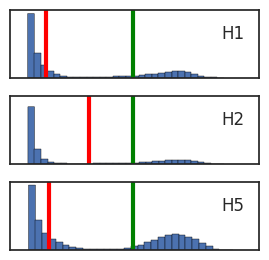

In [32]:
# plot subplots for Heathy group
# choose chain 0, dim CD123 (dimension of first cut)

chain = 3
dim = 12

first_cut_random_effect_H = [random_effect_H[id][chain][1][0] for id in range(5)]

subjects = ['H1','H2','H5']
#subjects = ['H1','H5']
subjects_id = [0,1,4]
fig,axarr = plt.subplots(len(subjects_id),1,figsize=(3,3),sharex=True)
bins = 50

cuts_re =  [find_first_cut(accepts_indiv_mp_lists_H[chain][id][-1])[1] for id in subjects_id]
cuts_template = find_first_cut(accepts_template_mp_H[chain][-1])[1]
print cuts_re
print cuts_template


bar_height = [8000,12000,4900]
for i in range(len(subjects)):
    print subjects_id[i]
    data_1d = data[subjects_id[i]][:,dim]
    axarr[i].plot([cuts_re[i],cuts_re[i]],[0,bar_height[i]], color='red',linewidth=3)
    axarr[i].plot([cuts_template,cuts_template],[0,bar_height[i]], color='green',linewidth=3)
    #sns.distplot(data_1d,ax = axarr[i],kde= False);
    axarr[i].plot([], c='white', label=subjects[i])
    axarr[i].legend(fontsize=12)
    axarr[i].hist(data_1d,bins = 30)
    axarr[i].yaxis.set_visible(False)

# plt.xticks(fontsize=12)
# axarr[i].plot([], c='green', label='Indiv MP')
# axarr[i].plot([], c='red', label='MP+RE')
plt.tight_layout()
plt.xticks([])
plt.show()